In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

\rm # what is thr prior p(y|x)?

\rm ## Bayesian Neural Networks

A Bayesian neural network is a probabilistic model that allows us to estimate uncertainty in predictions by representing the weights and biases of the network as probability distributions rather than fixed values. This allows us to *incorporate prior knowledge* about the weights and biases into the model, and *update our beliefs* about them as we observe data.

Mathematically, a Bayesian neural network can be represented as follows:

Given a set of input data $x$, we want to predict the corresponding output $y$. The neural network represents this relationship as a function $f(x, \theta)$, where $\theta$ are the weights and biases of the network. In a Bayesian neural network, we represent the weights and biases as probability distributions, so $f(x, \theta)$ becomes a probability distribution over possible outputs:

$$ p(y|x, \mathcal{D}) = \int p(y|x, \theta)p(\theta|\mathcal{D}) d\theta $$

where $p(y|x, \theta)$ is the likelihood function, which gives the probability of observing $y$ given $x$ and $\theta$, and $p(\theta|\mathcal{D})$ is the posterior distribution over the weights and biases given the observed data $\mathcal{D}$.

To make predictions, we use the posterior predictive distribution:

$$ p(y^*|x^*, \mathcal{D}) = \int p(y^*|x^*, \theta)p(\theta|\mathcal{D}) d\theta $$

where $x^*$ is a new input and $y^*$ is the corresponding predicted output.

To estimate the (intractable) posterior distribution $p(\theta|\mathcal{D})$, we can use either Markov Chain Monte Carlo (MCMC) or Variational Inference (VI).

# Generate noisy observations from sinusoidal function

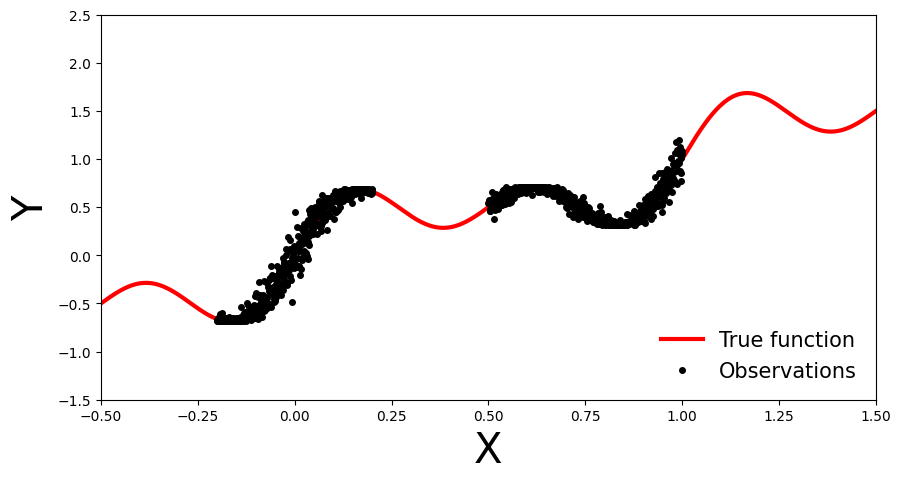

In [2]:
x_obs = np.hstack([np.linspace(0.5, 1, 500), np.linspace(-0.2, 0.2, 500)])
ε = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + ε)) + 0.3 * np.sin(4 * np.pi * (x_obs + ε)) + ε # y = x + 0.3 * sin(2 \pi x) + 0.3 * sin(4 \pi x) + ε

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

x_test = torch.linspace(-0.5, 1.5, 3000)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'r-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

(array([59., 23., 14., 11., 10.,  6.,  2.,  9., 10.,  5.,  9.,  1.,  4.,
         4.,  5.,  5.,  4.,  4.,  4.,  1.,  4.,  4.,  3.,  6.,  1.,  4.,
         3.,  3.,  4.,  5.,  7.,  6.,  5.,  2.,  3.,  3.,  2.,  2.,  4.,
         4.,  3.,  2.,  4.,  3.,  4.,  0.,  4.,  3.,  2.,  5.,  2.,  2.,
         4., 57., 35., 20., 16., 22., 25., 17., 22., 17., 16., 18., 15.,
        26., 21., 29., 23., 31., 33., 48., 79., 51., 31.,  4.,  2.,  4.,
         3.,  3.,  1.,  5.,  4.,  1.,  2.,  2.,  1.,  2.,  1.,  0.,  2.,
         0.,  3.,  1.,  1.,  1.,  0.,  0.,  1.,  1.]),
 array([-0.68631395, -0.66744899, -0.64858403, -0.62971907, -0.61085411,
        -0.59198914, -0.57312418, -0.55425922, -0.53539426, -0.5165293 ,
        -0.49766433, -0.47879937, -0.45993441, -0.44106945, -0.42220449,
        -0.40333952, -0.38447456, -0.3656096 , -0.34674464, -0.32787968,
        -0.30901472, -0.29014975, -0.27128479, -0.25241983, -0.23355487,
        -0.21468991, -0.19582494, -0.17695998, -0.15809502, -0.139230

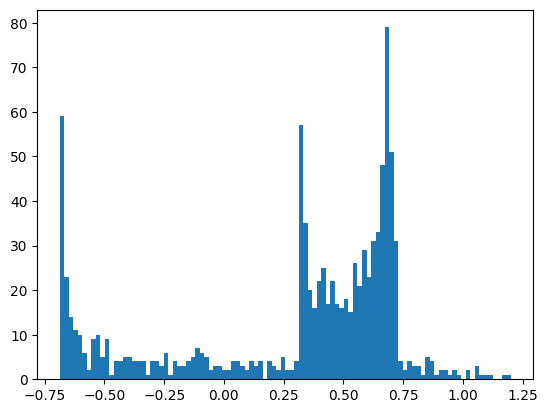

In [5]:
plt.hist(y_obs, bins=100)

Utility function to plot predictions, prediction mean, true function and the observed data

In [6]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    # ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

In [7]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

# Bayesian Neural Network with Gaussian Prior and Likelihood
The BNN employs a Gaussian prior on the weights and a Gaussian likelihood function for the data. The network is a shallow neural network with two hidden layers, each with 20 neurons each.

To be specific, we use the following prior on the weights $\theta$:

$p(\theta) = \mathcal{N}(\mathbf{0}, \cdot\mathbb{I}),$ where $\mathbb{I}$ is the identity matrix.
(Assume same prior for all the weights and biases)

To train the network, we define a likelihood function comparing the predicted outputs of the network with the actual data points:

$p(y_i| x_i, \theta) = \mathcal{N}\big(NN_{\omega}(x_i), \sigma_n ^2\big)$, with prior $\sigma_n \sim U(0,1)$ .

Using $\sigma_n ^2$ instead of $\sigma_n$ in the likelihood function to avoid negative values for the standard deviation

\rm ## Why is it called mean-field VI?
\rm For the full-covariance Gaussian approximate posterior, the model weights for each layer θi are distributed according to the multivariate Gaussian distribution $\mathcal{N}(\bm{\mu}_i, \bm{\Sigma}_i)$.
The mean-field approximation restricts $\bm{\Sigma}_i$ to be a diagonal covariance matrix, or equivalently assumes that the probability distribution can be expressed as a product of individual weight distributions:
$$
\mathcal{N}(\bm{\mu}_i, \bm{\Sigma}_i) = \Pi_j \mathcal{N}(\mu_{ij}, \sigma_{ij})
$$
The mean-field approximation greatly reduces the computational cost of both forward and backwards propagation, and reduces the number of parameters required to store the model from order $n^2$ in the number of weights to order $n$.

In [8]:
class Model(PyroModule):
    def __init__(self,h1, h2, prior_sigma):
        super().__init__()
        '''
        Define the model for the BNN
        param h1: number of neurons in the first hidden layer
        param h2: number of neurons in the second hidden layer
        param prior_sigma: standard deviation of the prior distribution of the weights and biases
        '''
        self.fc1 = PyroModule[nn.Linear](1, h1) # input to hidden layer
        self.fc2 = PyroModule[nn.Linear](h1, h2) # hidden layer 1 to hidden layer 2
        self.fc3 = PyroModule[nn.Linear](h2, 1) # hidden layer 2 to output layer

        # set priors for all weights and biases
        self.fc1.weight = PyroSample(dist.Normal(0., prior_sigma).expand([h1, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., prior_sigma).expand([h1]).to_event(1))
        
        self.fc2.weight = PyroSample(dist.Normal(0., prior_sigma).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., prior_sigma).expand([h2]).to_event(1))
        
        self.fc3.weight = PyroSample(dist.Normal(0., prior_sigma).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., prior_sigma).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze() # output of the neural network: mu = neural_net_theta(x_i)
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.)) # prior on \sigma (std dev of posterior of y; y|x, $\theta$) of p(y_i | x_i, \theta) = N( neural_net_theta(x_i), \sigma^2 )
        
        # sample y (observed) from the normal distribution with mean mu (neural_net_theta(x_i)) and std dev \sigma
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y) # y_i ~ N( neural_net_theta(x_i), \sigma^2 )
        return mu

prior of the \sigma: dictated by the problem!
network must be strictly convex in some cases
typically use normal distribution prior: play around with the prior 
\sigma: influence of prior (gamma and lognormla and uniform)

In [9]:
import logging

\rm ## Train BNNs with mean-field variational inference

\rm We will now move on to variational inference. Since the normalized posterior probability density $p(\theta|\mathcal{D})$ is intractable, we approximate it with a tractable parametrized density $q_{\phi}(\theta)$ in a family of probability densities $\mathcal{Q}$. The variational parameters are denoted by $\phi$ and the variational density is called the "guide" in Pyro. The goal is to find the variational probability density that best approximates the posterior by minimizing the KL divergence $$KL\big(q_{\phi}(\theta)||p(\theta|\mathcal{D})\big)$$ with respect to the variational parameters.
However, directly minimizing the KL divergence is not tractable because we assume that the posterior density is intractable. To solve this, we use Bayes theorem to obtain
$$
\log p(\mathcal{D}|\theta) = KL\big(q_{\phi}(\theta)||p(\theta|\mathcal{D})\big) + ELBO(q_{\phi}(\theta)),
$$
where $ELBO(q_{\phi}(\theta))$ is the *Evidence Lower Bound*, given by
$$
ELBO(q_{\phi}(\theta)) = \mathbb{E}_{\theta \sim q_{\phi}(\theta)}\big[\log p(y|x,\theta) \big] - KL\big(q_{\phi}(\theta) || p(\theta) \big).
$$
$$
ELBO(q_{\phi}(\theta)) = \mathbb{E}_{\theta \sim q_{\phi}(\theta)}\big[\log p(\mathcal{D},\theta) \big] - KL\big(q_{\phi}(\theta) || p(\theta) \big).
$$
By maximizing the ELBO, we indirectly minimize the KL divergence between the variational probability density and the posterior density.
Minimize negative ELBO using the loss function:
$$
\mathcal{L} = KL\big(q_{\phi}(\theta) || p(\theta) \big) - \mathbb{E}_{\theta \sim q_{\phi}(\theta)}\big[\log p(\mathcal{D},\theta) \big]
$$

### Training of BNN with SVI

In [10]:
model = Model(20,20,1.) # 20 neurons in each hidden layer and std dev of prior distribution of weights and biases = 1
guide = AutoDiagonalNormal(model) # This implementation of AutoContinuous uses a Normal distribution with a diagonal covariance matrix to construct a guide over the entire latent space.
                                    #This is because of the mean-field VI assumption

adam = pyro.optim.Adam({"lr": 0.001, "betas": (0.999, 0.999)}, {"clip_norm": 2.}) # optimzier for the guide
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()

num_epochs = 50000
bar = trange(num_epochs)
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()
loss_svi = []
for epoch in bar:
    elbo_loss = svi.step(x_train, y_train)
    bar.set_postfix(loss=f'{elbo_loss / x_obs.shape[0]:.3f}')
    loss_svi.append(elbo_loss)
    if epoch % 1000 == 0:
        logging.info("Elbo loss: {}".format(elbo_loss))
        print("Elbo loss: {}".format(elbo_loss))
        

  0%|          | 0/50000 [00:00<?, ?it/s]

Elbo loss: 1719.8387542963028
Elbo loss: 1035.787489414215
Elbo loss: 484.7278485298157
Elbo loss: 504.03841865062714
Elbo loss: 46.46225452423096
Elbo loss: 226.65567922592163
Elbo loss: 62.50129944086075
Elbo loss: -148.783553481102
Elbo loss: -158.10747545957565
Elbo loss: -234.78401565551758
Elbo loss: -194.7504500746727
Elbo loss: -266.3802592754364
Elbo loss: -505.40434235334396
Elbo loss: -553.4995667934418
Elbo loss: -666.3823148608208
Elbo loss: -359.011283159256
Elbo loss: -781.5375740528107
Elbo loss: -694.0166265964508
Elbo loss: -799.5807945728302
Elbo loss: -718.3191653490067
Elbo loss: -825.0341188907623
Elbo loss: -762.550811290741
Elbo loss: -823.7126966714859
Elbo loss: -236.3571525812149
Elbo loss: 1835.0311627388
Elbo loss: -822.0909855365753
Elbo loss: -819.8213095664978
Elbo loss: -771.736029624939
Elbo loss: -694.8742949962616
Elbo loss: 167.91252160072327
Elbo loss: -841.2888650894165
Elbo loss: -821.6772315502167
Elbo loss: -844.123396396637
Elbo loss: -859.000

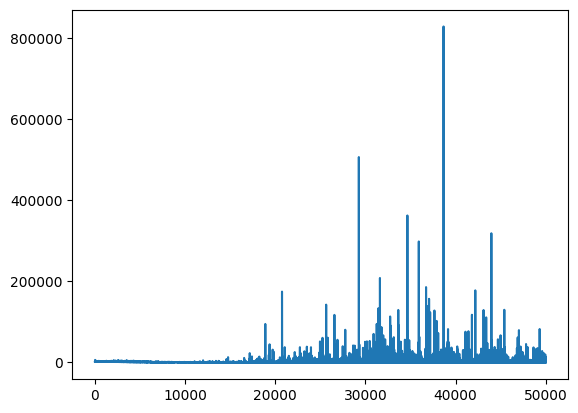

In [11]:
plt.plot(loss_svi)

In [12]:
print(model)

Model(
  (fc1): PyroLinear(in_features=1, out_features=20, bias=True)
  (fc2): PyroLinear(in_features=20, out_features=20, bias=True)
  (fc3): PyroLinear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


we compute the predictive distribution sampling from the trained variational density.

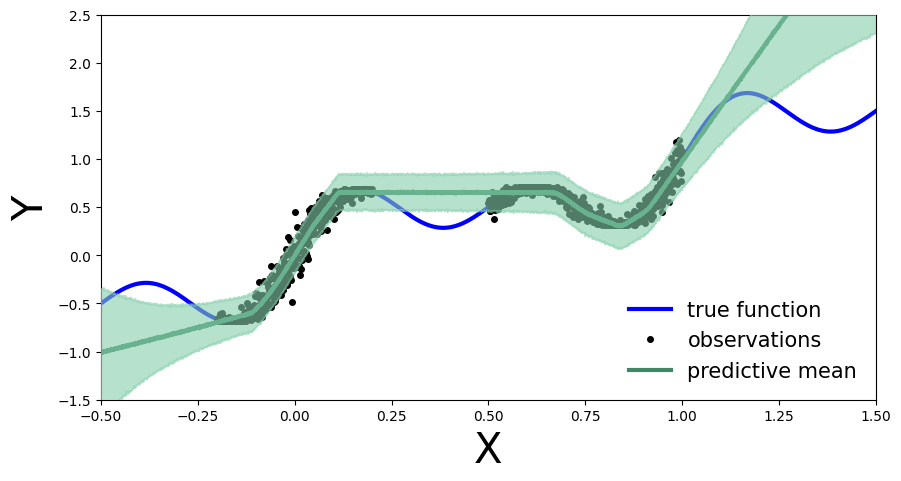

In [13]:
predictive_svi = Predictive(model, guide=guide, num_samples=500)
preds_svi = predictive_svi(x_test)
plot_predictions(preds_svi)

just reshaping and stuff for the samples of each param and creating a dict, svi_samples, from y_pred_samples

In [14]:
svi_samples = {}
for k, v in predictive_svi(x_test).items():
    if k != "obs":
        print(k, v.shape)
        svi_samples[k] = v.detach().cpu().numpy()

fc1.weight torch.Size([500, 1, 20, 1])
fc1.bias torch.Size([500, 1, 20])
fc2.weight torch.Size([500, 1, 20, 20])
fc2.bias torch.Size([500, 1, 20])
fc3.weight torch.Size([500, 1, 1, 20])
fc3.bias torch.Size([500, 1, 1])
sigma torch.Size([500, 1])


Means and standard deviations of weights and biases of each neuron in layer 1

In [22]:
layer1  = pd.DataFrame( {'fc1.weight-mean': list(torch.mean(torch.Tensor(svi_samples['fc1.weight']), dim=0)[0].numpy().flatten()),
 'fc1.weight- std': list(torch.std(torch.Tensor(svi_samples['fc1.weight']), dim=0)[0].numpy().flatten()),
  'fc1.bias-mean': list(torch.mean(torch.Tensor(svi_samples['fc1.bias']), dim=0).numpy().flatten()),
   'fc2.bias-std': list(torch.std(torch.Tensor(svi_samples['fc1.bias']), dim=0)[0].numpy().flatten())}
)
layer1

,fc1.weight-mean,fc1.weight- std,fc1.bias-mean,fc2.bias-std
0,-1.121760,0.906908,-2.479580,0.859108
1,-1.147678,0.923484,-2.692838,0.866230
2,-1.570242,0.023737,0.177478,0.001529
3,-1.200562,0.914703,-1.996542,0.774512
4,0.972886,0.005480,-0.887940,0.005433
5,-1.242787,0.999797,-2.195337,0.780139
6,-1.148900,1.007735,-2.444760,0.880185
7,-0.688108,0.588327,-0.901799,0.376089
8,1.140082,0.004804,-0.766255,0.003834
9,-1.094488,0.964149,-2.706753,0.892134


Mean of biases in layer 2

In [ ]:
torch.mean(torch.Tensor(svi_samples['fc2.bias']), dim=0)

Standard deviation of biases in layer 2

In [19]:
torch.std(torch.Tensor(svi_samples['fc2.bias']), dim=0)

tensor([[0.8791, 0.9123, 0.8735, 0.9379, 0.0074, 0.0122, 0.8806, 0.8044, 0.8604,
         0.8564, 0.8559, 0.8267, 0.0034, 0.8460, 0.8747, 0.8563, 0.0064, 0.7712,
         0.8376, 0.0085]])

Mean of biases in layer 2

In [20]:
torch.mean(torch.Tensor(svi_samples['fc2.weight']), dim=0)[0]

tensor([[ 3.9340e-02, -6.5256e-02, -6.5376e-01, -1.5381e-02, -3.1710e-02,
         -2.1302e-02, -3.5703e-02, -7.5373e-02, -4.9777e-01,  1.4124e-02,
          5.7264e-02, -2.5802e-03, -3.1519e-01,  4.6669e-02, -7.1837e-02,
         -2.0509e-02, -1.1733e-01,  2.9417e-02,  6.5601e-02, -1.8613e-02],
        [ 2.2978e-02,  6.8929e-02, -6.1239e-01, -1.1218e-02, -6.2650e-02,
          5.5219e-02, -7.8193e-02,  7.7053e-02, -3.5166e-01, -5.7777e-02,
         -2.0944e-02, -3.0095e-02, -2.2723e-01,  3.5770e-02,  9.7450e-03,
         -4.5521e-03, -2.3348e-02, -6.3985e-02,  2.4687e-03,  3.6573e-03],
        [ 2.8015e-02, -3.3304e-02, -4.9046e-01,  1.0232e-01,  1.2970e-02,
          3.2771e-03, -2.9057e-02,  7.9954e-04, -3.1850e-01,  8.6654e-02,
         -3.6540e-02,  9.5467e-02, -1.7392e-01, -6.3705e-02,  5.1949e-02,
         -1.6770e-02, -1.1385e-01, -8.5238e-02, -3.6626e-02, -1.2934e-02],
        [ 9.5169e-03, -2.8471e-02, -4.4084e-01, -2.8231e-02,  1.1380e-02,
         -1.3149e-01,  1.9119e-02, 

Mean of biases in layer 2

In [21]:
torch.std(torch.Tensor(svi_samples['fc2.weight']), dim=0)[0]

tensor([[1.0246, 0.9877, 1.0210, 1.0132, 0.9519, 1.0002, 0.9988, 1.0150, 0.9668,
         1.0490, 0.9910, 1.0534, 1.0396, 0.9904, 1.0373, 0.9906, 1.0105, 0.9489,
         1.0426, 1.0470],
        [0.9734, 0.9981, 0.9394, 1.0404, 0.9783, 0.9815, 1.0319, 1.0082, 1.0033,
         1.0168, 1.0153, 1.0036, 0.9959, 1.0144, 1.0364, 0.9513, 1.0006, 0.9422,
         1.0050, 1.0038],
        [0.9703, 0.9602, 0.9996, 0.9815, 0.9374, 0.9240, 0.9703, 0.9873, 0.9580,
         1.0618, 0.9585, 0.9583, 0.9300, 1.0407, 0.9991, 1.0570, 1.0090, 1.0370,
         0.9799, 0.9725],
        [1.0041, 0.9385, 0.9787, 0.9931, 0.9895, 1.0061, 1.0388, 1.0514, 1.0029,
         0.9789, 1.0280, 1.0392, 0.9719, 0.9443, 0.9773, 0.9933, 1.0313, 0.9538,
         1.0533, 0.9763],
        [1.0159, 0.9711, 0.0795, 0.9959, 0.3794, 1.0064, 0.9378, 0.9934, 0.0526,
         0.9749, 1.0458, 1.0123, 0.0646, 1.0383, 1.0505, 1.0045, 0.4324, 0.9706,
         0.9739, 1.0311],
        [0.9660, 0.9878, 0.0417, 1.0098, 0.9927, 0.9380, 0.9

## Markov chain Monte Carlo (HMC)

In [388]:
from pyro.infer import MCMC, HMC

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
hmc_kernel = HMC(model, step_size=0.0001,
 trajectory_length=3, 
   full_mass=False,
    jit_compile=False)

# Define MCMC sampler, get 'num_samples' posterior samples with burin in 'warmup_steps'
mcmc = MCMC(hmc_kernel, num_samples=50, warmup_steps=10)

# Run MCMC sampler
mcmc.run(x_train, y_train)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 60/60 [12:59, 12.99s/it, step size=2.71e-04, acc. prob=0.985]


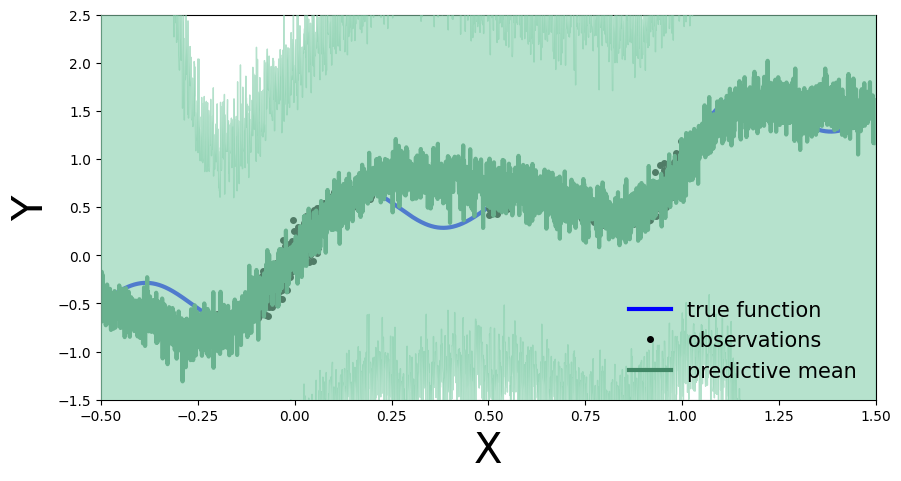

In [389]:
predictive_hmc = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds_hmc = predictive_hmc(x_test)
plot_predictions(preds_hmc)

## Markov Chain Monte Carlo (NUTS)

In [23]:
from pyro.infer import MCMC, NUTS

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
nuts_kernel = NUTS(model, jit_compile=False)

# Define MCMC sampler, get 'num_samples' posterior samples with burin in 'warmup_steps'
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=50)

# Run MCMC sampler
mcmc.run(x_train, y_train)

nuts_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 550/550 [11:27,  1.25s/it, step size=9.47e-04, acc. prob=0.916]


We calculate and plot the predictive distribution.

In [24]:
predictive_nuts = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds_nuts = predictive_nuts(x_test)

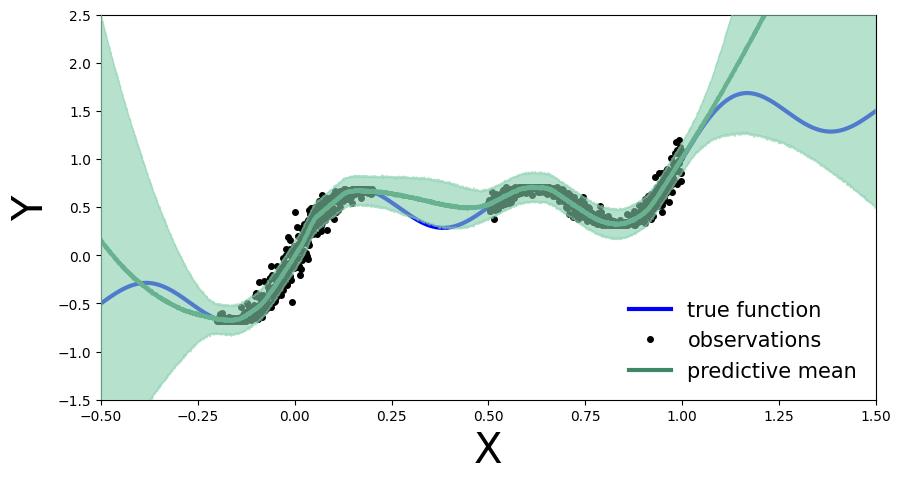

In [25]:
plot_predictions(preds_nuts)

### Comparing Posterior Distributions¶

In [26]:
import seaborn as sns

In [272]:
sns.distplot(svi_samples[sites[3]], ax=ax, label="SVI (DiagNormal)")
sns.distplot(nuts_samples[sites[3]], ax=ax, label="HMC")
ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

/var/folders/f6/9mr1g0xj6mqf2jl8_cvr2lwc0000gn/T/ipykernel_4243/2769289442.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(svi_samples[sites[3]], ax=ax, label="SVI (DiagNormal)")
/var/folders/f6/9mr1g0xj6mqf2jl8_cvr2lwc0000gn/T/ipykernel_4243/2769289442.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

### Plot of the posteriors of weights of layer 1 (SVI and NUTS)

/var/folders/f6/9mr1g0xj6mqf2jl8_cvr2lwc0000gn/T/ipykernel_9726/2840318329.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neuron_weights_svi, ax=axs[i], label="SVI (DiagNormal)")
/var/folders/f6/9mr1g0xj6mqf2jl8_cvr2lwc0000gn/T/ipykernel_9726/2840318329.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

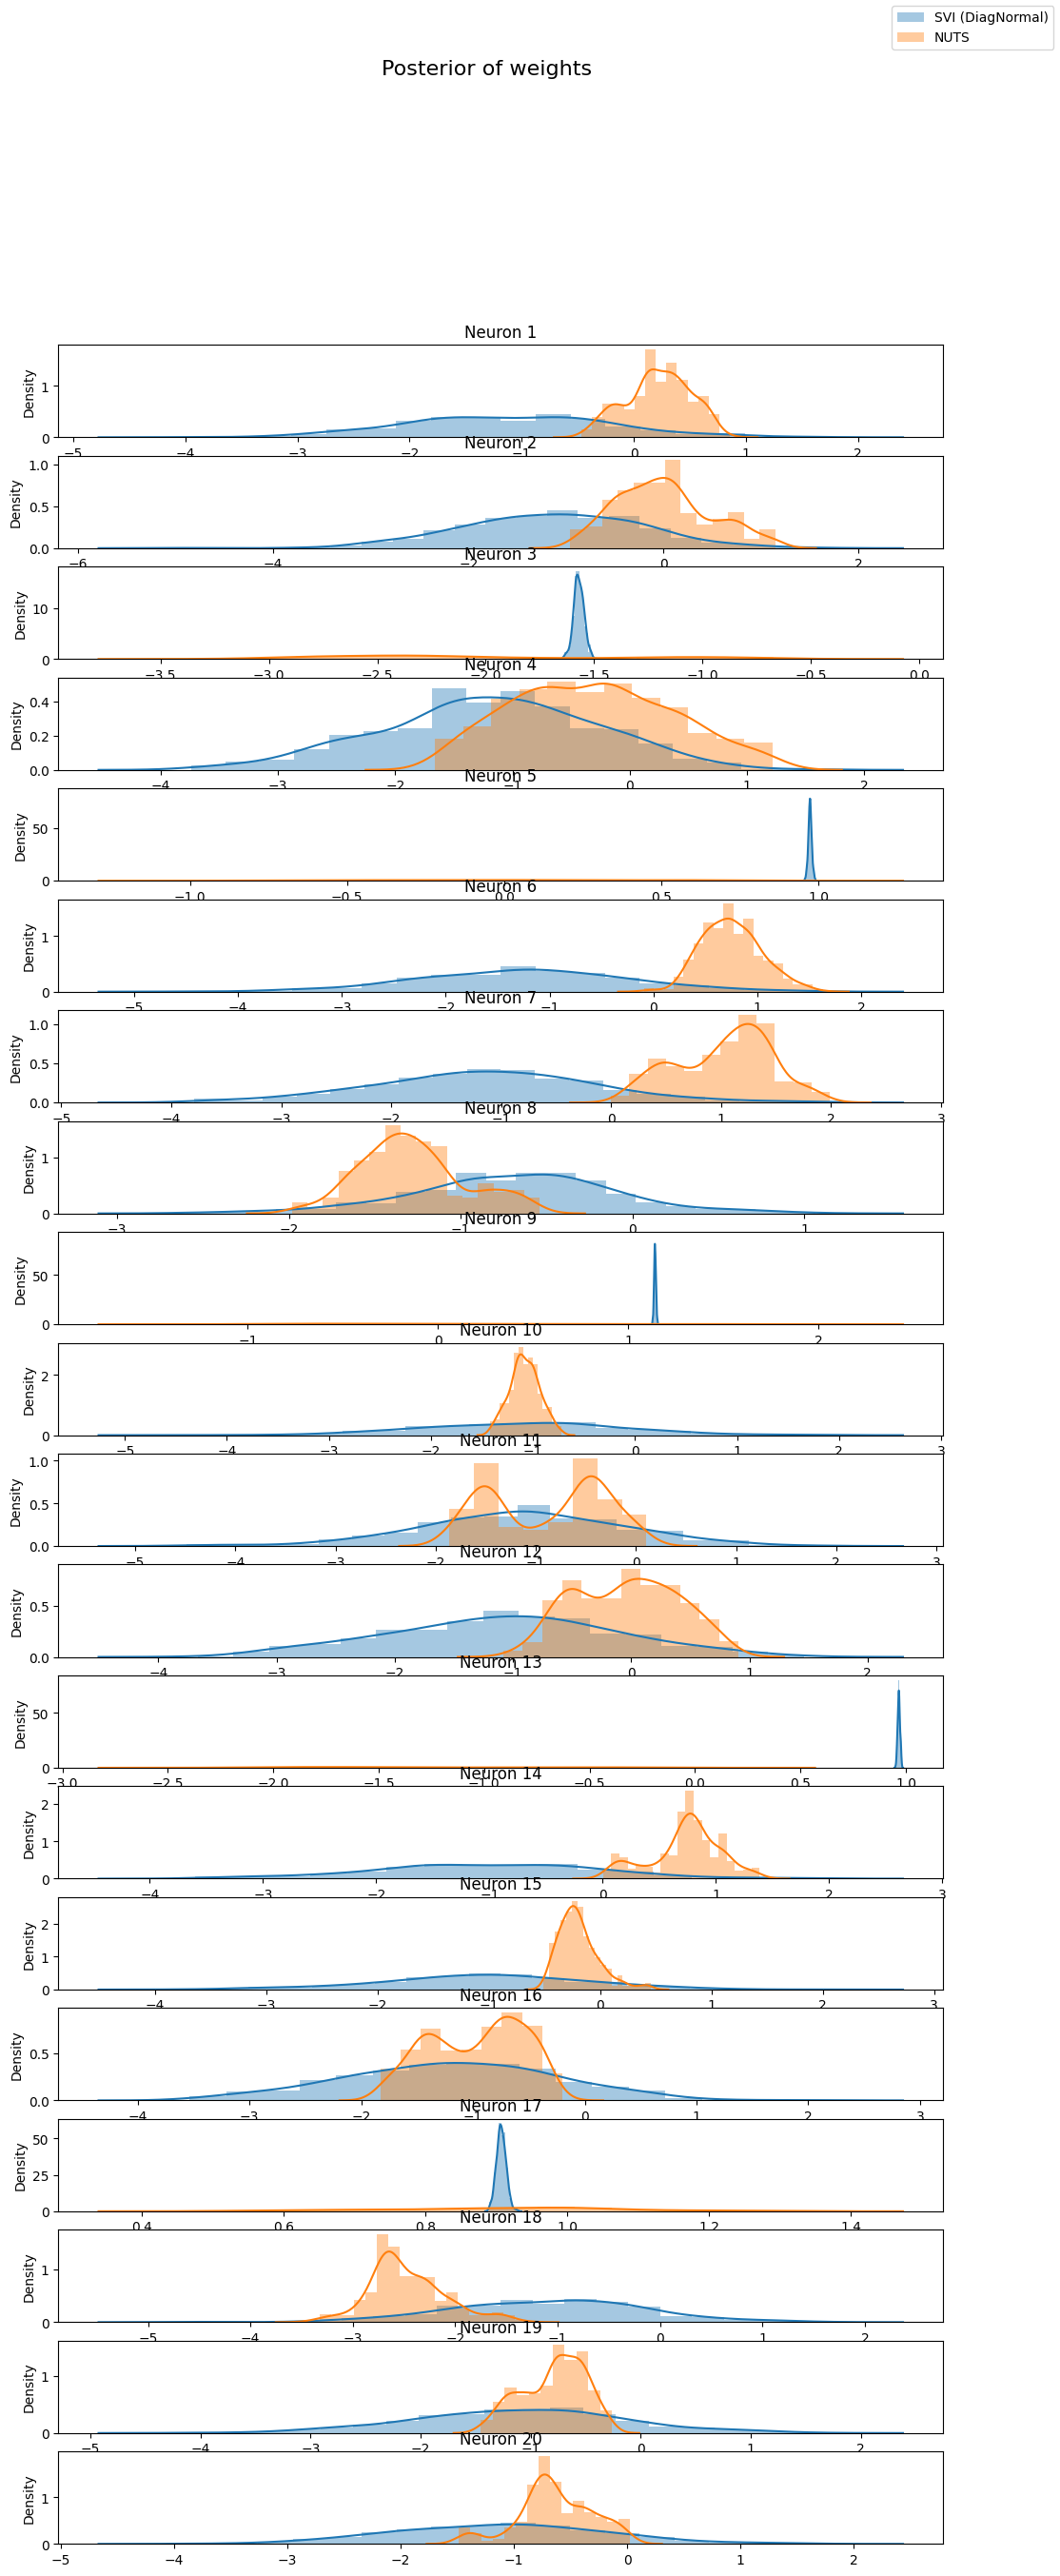

In [27]:
sites = list(svi_samples.keys())
num_neurons = svi_samples[sites[0]].reshape(500,-1).shape[1]
fig, axs = plt.subplots(nrows=num_neurons, figsize=(12, 10*3))
fig.suptitle(f"Posterior of weights", fontsize=16)

    # If there's only one neuron, make axs a list
if num_neurons == 1:
    axs = [axs]

for i in range(num_neurons):
    neuron_weights_svi = svi_samples[sites[0]].reshape(500,-1)[:, i]
    neuron_weights_nuts = nuts_samples[sites[0]].reshape(500,-1)[:, i]

    sns.distplot(neuron_weights_svi, ax=axs[i], label="SVI (DiagNormal)")
    sns.distplot(neuron_weights_nuts, ax=axs[i], label="NUTS")
    axs[i].set_title(f"Neuron {i+1}")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [ ]:
# sites = list(svi_samples.keys())
# for site in sites:
#     num_neurons = svi_samples[site].reshape(500,-1).shape[1]
#     fig, axs = plt.subplots(nrows=num_neurons, figsize=(12, 10))
#     fig.suptitle(f"Marginal Posterior density - {site}", fontsize=16)

#     # If there's only one neuron, make axs a list
#     if num_neurons == 1:
#         axs = [axs]

#     for i in range(num_neurons):
#         neuron_weights_svi = svi_samples[site].reshape(500,-1)[:, i]
#         neuron_weights_nuts = nuts_samples[site].reshape(500,-1)[:, i]

#         sns.distplot(neuron_weights_svi, ax=axs[i], label="SVI (DiagNormal)")
#         sns.distplot(neuron_weights_nuts, ax=axs[i], label="HMC")
#         axs[i].set_title(f"Neuron {i+1}")

#     handles, labels = axs[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper right')

# plt.show()

# Define non-Bayesian Neural Network (Point Estimates)

In [29]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=2, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)
        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

## Train one deterministic NN

Utility functions

In [32]:
def get_simple_data_train():
    x = np.linspace(-.2, 0.2, 500)
    x = np.hstack([x, np.linspace(.6, 1, 500)])
    eps = 0.02 * np.random.randn(x.shape[0])
    y = x + 0.3 * np.sin(2 * np.pi * (x + eps)) + 0.3 * np.sin(4 * np.pi * (x + eps)) + eps
    x_train = torch.from_numpy(x).float()[:, None]
    y_train = torch.from_numpy(y).float()
    return x_train, y_train

def train(net, train_data):
    x_train, y_train = train_data
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y_train, net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
    return net

checking the optimum number of neurons in each layer (fixing 2 hidden layers) by trial and error

In [33]:
train_data = get_simple_data_train()
x_test = torch.linspace(-.5, 1.5, 3000)[:, None]  # test over the whole range
l = [10,20,30,40]
predictions = []

for i in l:
    net_MLP = MLP(hidden_dim=i, n_hidden_layers=2)
    net_MLP_train = train(net_MLP, train_data)
    y_preds_single_NN = net_MLP_train(x_test).clone().detach().numpy()
    predictions.append(y_preds_single_NN)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

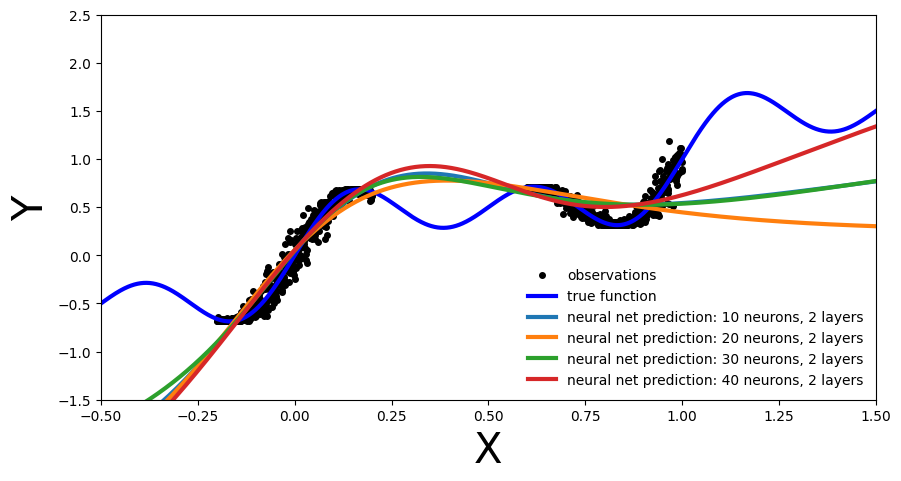

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-.5, 1.5])
plt.ylim([-1.5, 2.5])
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

x_train, y_train = get_simple_data_train()

x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")

for i, y_preds_single_NN in zip(l, predictions):
    ax.plot(x_test, y_preds_single_NN, linewidth=3, label=f'neural net prediction: {i} neurons, 2 layers')

plt.legend(loc=4, fontsize=10, frameon=False)
plt.show()

from the figure, it seems that 20 neurons per layer is a suitable architecture to train the data

  0%|          | 0/3000 [00:00<?, ?it/s]

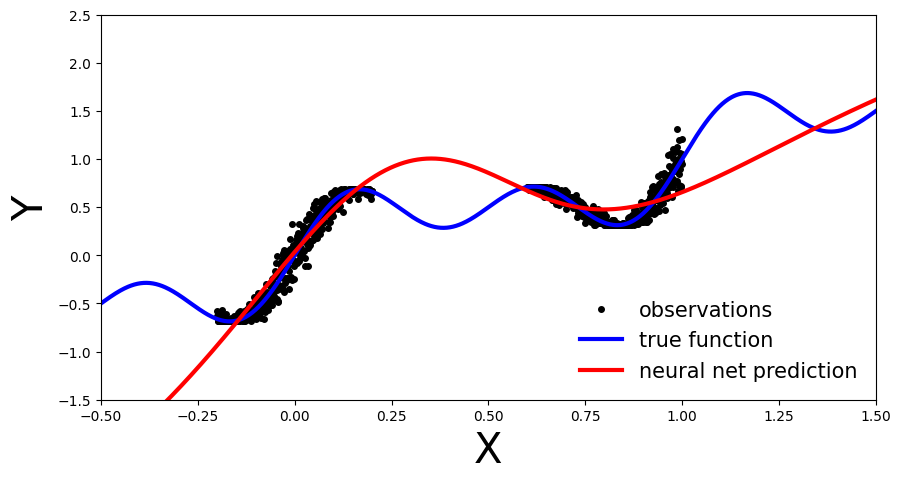

In [35]:
train_data = get_simple_data_train()
x_test = torch.linspace(-.5, 1.5, 3000)[:, None]  # test over the whole range

net_MLP = MLP(hidden_dim=20, n_hidden_layers=2)
net_MLP_train = train(net_MLP, train_data)
y_preds_single_NN = net_MLP_train(x_test).clone().detach().numpy()

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-.5, 1.5])
plt.ylim([-1.5, 2.5])
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

x_train, y_train = get_simple_data_train()

x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x_test, y_preds_single_NN, 'r-', linewidth=3, label='neural net prediction')

plt.legend(loc=4, fontsize=15, frameon=False)
plt.show()

# Deep Ensemble

In [43]:
ensemble_size = 5
ensemble = [MLP(hidden_dim=20, n_hidden_layers=2) for _ in range(ensemble_size)]
for net in ensemble:
    train(net, train_data)

y_preds_ensemble = [np.array(net(x_test[:, None]).clone().detach().numpy()) for net in ensemble]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Plot each ensemble member’s predictive function.

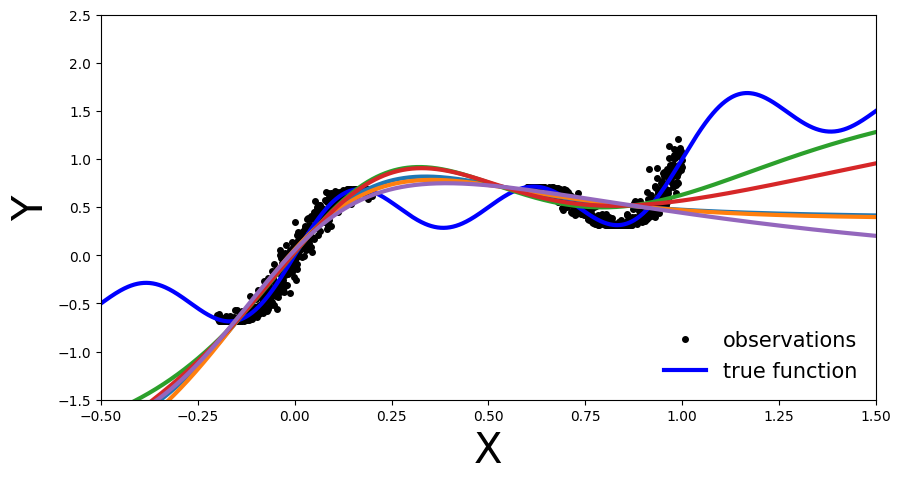

In [45]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([-.5, 1.5])
    plt.ylim([-1.5, 2.5])
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    x_train, y_train = get_simple_data_train()

    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

    ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.show()

def plot_multiple_predictions(x_test, y_preds):
    def add_multiple_predictions(ax):
        for idx in range(len(y_preds)):
            ax.plot(x_test, y_preds[idx], '-', linewidth=3)

    plot_generic(add_multiple_predictions)

plot_multiple_predictions(x_test, y_preds_ensemble)


visualize the ensemble's **uncertainty bands**.
From a Bayesian perspective we want to quantify the model's uncertainty on its prediction. This is done via the marginal $p(y|x, D)$, which can be computed as:

$$
p(y|x, D) = \int_{\theta}p(y|x,\theta')p(\theta'|D)d\theta'
$$

In practice, for Deep Ensembles we approximate the above by computing the mean and standard deviation across the ensemble. Meaning $p(\theta|D)$ represents the parameters of one of the trained models, $\theta_{i} ∼ p(\theta|D)$, which we then use to compute $y_{i} = f(x,\theta_{i})$, representing $p(y|x,\theta')$.

Visualizing the uncertainty bands

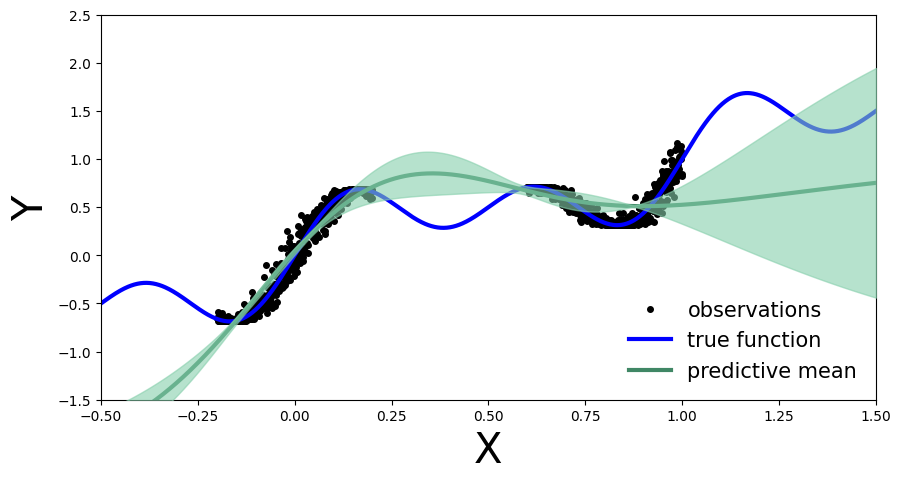

In [42]:
def plot_uncertainty_bands(x_test, y_preds):
    y_preds = np.array(y_preds)
    y_mean = y_preds.mean(axis=0)
    y_std = y_preds.std(axis=0)

    def add_uncertainty(ax):
        ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
        ax.fill_between(x_test.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plot_generic(add_uncertainty)

plot_uncertainty_bands(x_test, y_preds_ensemble)

Now we see the benefit of a Bayesian approach. Outside the training region we not only have the point estimate, but also model’s uncertainty about its prediction.

strengths and weaknesses (?) of each approach
compare with gpr (?)
prediction uncertainty (interpolation and extrapolation)
predicting outside the range of data
magnitude of noise and its effect on predictive capability
distribution of the weights (?)/ posterior
joint distribution of posterior of weights: hmc vs vi approache maybe (?)
some weights might be deterministic (?), the effect of removing/including these 
put in the basics of the basics of the formulations



## GPR

In [46]:
import GPy
GPy.tests()

ModuleNotFoundError: No module named 'GPy'

# CHECK THIS TMR!

# Monte Carlo Dropout
We can reuse our existing network architecture, the only alteration is that during the forward pass we randomly switch off (zero) some of the elements of the input tensor.

The Bayesian interpretation of MC-Dropout is that we can see each dropout configuration as a different sample from the approximate posterior distribution  $\theta_{i} ∼ q(\theta|D)$. 

In [413]:
net_dropout = MLP(hidden_dim=20, n_hidden_layers=2, use_dropout=True)
net_dropout = train(net_dropout, train_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [414]:
num_dropout_samples = 100
# compute predictions, resampling dropout mask for each forward pass
y_preds = [net_dropout(x_test[:,None]).clone().detach().numpy() for _ in range(num_dropout_samples)]
y_preds = np.array(y_preds)

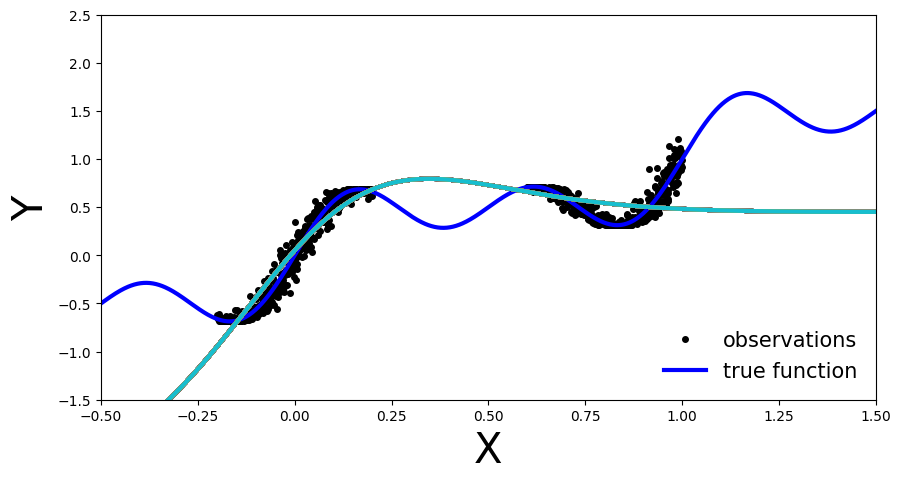

In [415]:
plot_multiple_predictions(x_test, y_preds)

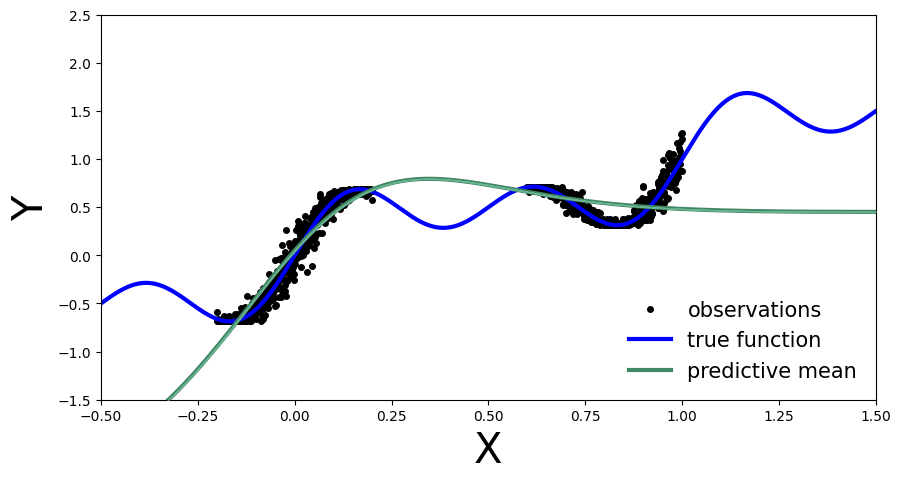

In [416]:
plot_uncertainty_bands(x_test, y_preds)

In [22]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp


class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=0.1,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))

In [28]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input
from keras.models import Model

batch_size = len(x_obs)
num_batches = len(x_obs) / batch_size

kl_weight = 1.0 / num_batches
prior_params = {
    'prior_sigma_1': 1.0, 
    'prior_sigma_2': 1.0, 
    'prior_pi': 0.5 
}

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(1, kl_weight, **prior_params)(x)

model = Model(x_in, x)

In [39]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_obs, y_pred, sigma=0.02):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse'])
model.fit(x_obs, y_obs, batch_size=batch_size, epochs=5000, verbose=0)

In [40]:
import tqdm

X_test = np.linspace(-0.5, 1.5, 3000).reshape(-1, 1)
y_pred_list = []

for i in range(500):#tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test, verbose=0)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

# plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
# plt.scatter(x_obs, y_obs, marker='+', label='Training data')
# plt.fill_between(X_test.ravel(), 
#                  y_mean + 2 * y_sigma, 
#                  y_mean - 2 * y_sigma, 
#                  alpha=0.5, label='Epistemic uncertainty')
# plt.title('Prediction')
# plt.legend();

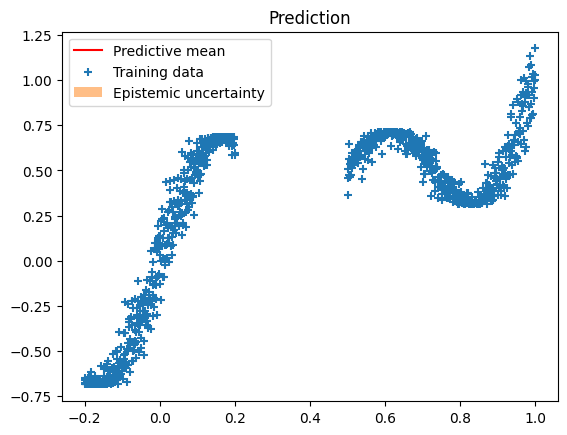

In [41]:
plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x_obs, y_obs, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend()

In [42]:
y_mean

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)